In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from fuzzywuzzy import fuzz
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import re
import distance

In [2]:
traindata = pd.read_csv("data/train.csv")
testdata = pd.read_csv('data/test.csv')

## Basic EDA

In [3]:
print(traindata.columns)
print(traindata.is_duplicate.unique())
print(traindata.is_duplicate.value_counts())
print(traindata.shape)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')
[0 1]
0    255027
1    149263
Name: is_duplicate, dtype: int64
(404290, 6)


We have 404290 training data points. And only 36.92% are positive. That means it is an imbalanced dataset.

In [4]:
print(testdata.columns)
print(testdata.shape)

Index(['test_id', 'question1', 'question2'], dtype='object')
(2345796, 3)


In [5]:
traindata.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
testdata.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


Test data don't have question ids. So the independent variables are question1, question2 and the dependent variable is is_duplicate.

In [7]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
traindata = traindata.dropna()
print(traindata.shape)

(404287, 6)


In [9]:
print(traindata.duplicated(('question1', 'question2')).sum())

0


0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64


<AxesSubplot:title={'center':'Distribution of classes'}>

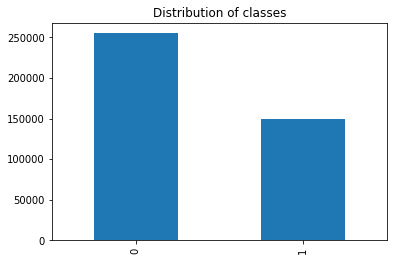

In [10]:
duplicate_value_counts = traindata.is_duplicate.value_counts()
print(duplicate_value_counts/duplicate_value_counts.sum())
plt.title('Distribution of classes')
duplicate_value_counts.plot.bar()

In [11]:
qids = np.append(traindata.qid1.values, traindata.qid2.values)
print(len(set(qids)))
print(len(qids))

537929
808574


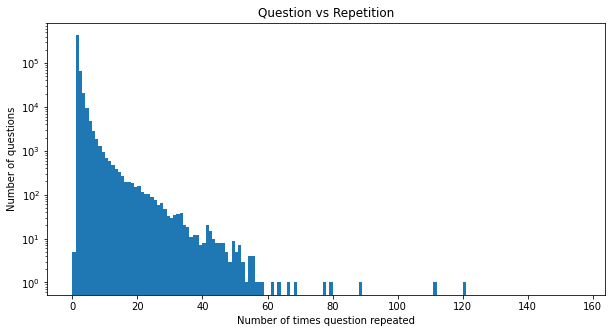

0 157


In [12]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,np.max(occurences)))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repetition')
plt.show()
print(np.min(occurences), np.max(occurences))

In [13]:
print(traindata.question1.apply(len).min())
print(traindata.loc[traindata.question1.apply(len).argmin()])
print(traindata.question2.apply(len).min())
print(traindata.loc[traindata.question2.apply(len).argmin()])

1
id                                                           3306
qid1                                                         6553
qid2                                                         6554
question1                                                       .
question2       Why is Cornell's endowment the lowest in the I...
is_duplicate                                                    0
Name: 3306, dtype: object
1
id                                                          47056
qid1                                                        84067
qid2                                                        84068
question1       Is there anywhere in the world offering pain m...
question2                                                       ?
is_duplicate                                                    0
Name: 47056, dtype: object


## Data Preprocessing

In [14]:
WNL = WordNetLemmatizer()
def cutter(word):
    if len(word) < 4:
        return word
    return WNL.lemmatize(WNL.lemmatize(word, "n"), "v")

In [15]:
def preprocess_text(string):
    string = string.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
        .replace("€", " euro ").replace("'ll", " will").replace("=", " equal ").replace("+", " plus ")
    
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    string = re.sub(r"([0-9]+)000000", r"\1m", string)
    string = re.sub(r"([0-9]+)000", r"\1k", string)
    string = ' '.join([cutter(w) for w in string.split()])
    
    bfs = BeautifulSoup(string)
    string = bfs.get_text()
    string = string.strip()
    return string

In [16]:
def data_cleaning(data):
    newdata = pd.DataFrame()
    newdata['question1_final'] = data["question1"].fillna("").apply(preprocess_text)
    newdata['question2_final'] = data["question2"].fillna("").apply(preprocess_text)
    return newdata

In [17]:
train_data = data_cleaning(traindata)

In [18]:
test_data = data_cleaning(testdata)

In [19]:
print(traindata.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [20]:
print(train_data.head())

                                     question1_final  \
0  what is the step by step guide to invest in sh...   
1   what is the story of kohinoor koh i noor diamond   
2  how can i increase the speed of my internet co...   
3   why am i mentally very lonely how can i solve it   
4  which one dissolve in water quikly sugar salt ...   

                                     question2_final  
0  what is the step by step guide to invest in sh...  
1  what would happen if the indian government ste...  
2  how can internet speed be increase by hack thr...  
3  find the remainder when math 23 24 math is div...  
4             which fish would survive in salt water  


We have:
- converted everything to lower case.
- removed contractions.
- replaced currency symbols with currency names.
- also removed hyperlinks.
- removed non-alphanumeric characters.
- removed inflections with word lemmatizer.
- also removed HTML tags.

## Feature Extraction

In [21]:
def doesMatch (q, match):
    q1, q2 = q['question1_final'], q['question2_final']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[match]==q2[match]:
        return 1
    else:
        return 0

In [22]:
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [23]:
def feature_extract(data):
    data['q1_char_num'] = data.question1_final.apply(len)
    data['q2_char_num'] = data.question2_final.apply(len)
    data['q1_word_num'] = data.question1_final.apply(lambda x: len(x.split()))
    data['q2_word_num'] = data.question2_final.apply(lambda x: len(x.split()))
    
    data['total_word_num'] = data['q1_word_num'] + data['q2_word_num']
    data['differ_word_num'] = abs(data['q1_word_num'] - data['q2_word_num'])
    data['same_first_word'] = data.apply(lambda x: doesMatch(x, 0), axis=1)
    data['same_last_word'] = data.apply(lambda x: doesMatch(x, -1), axis=1)
    
    data['total_unique_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split()))), axis=1)
    data['total_unique_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split())) - set(stopwords.words('english'))), axis=1)
    data['total_unique_word_num_ratio'] = data['total_unique_word_num'] / data['total_word_num']
    
    data['common_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split()))), axis=1)
    data['common_word_ratio'] = data['common_word_num'] / data['total_unique_word_num']
    data['common_word_ratio_min'] = data['common_word_num'] / data.apply(lambda x: min(len(set(x.question1_final.split())), len(set(x.question2_final.split()))), axis=1) 
    data['common_word_ratio_max'] = data['common_word_num'] / data.apply(lambda x: max(len(set(x.question1_final.split())), len(set(x.question2_final.split()))), axis=1) 
    
    data['common_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['common_word_withoutstopword_ratio'] = data['common_word_withoutstopword_num'] / data['total_unique_word_withoutstopword_num']
    data['common_word_withoutstopword_ratio_min'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: min(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    data['common_word_withoutstopword_ratio_max'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: max(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    
    data["fuzz_ratio"] = data.apply(lambda x: fuzz.ratio(x['question1_final'], x['question2_final']), axis=1)
    data['fuzz_QRatio'] = data.apply(lambda x: fuzz.QRatio(x['question1_final'], x['question2_final']), axis=1)
    data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(x['question1_final'], x['question2_final']), axis=1)
    data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x['question1_final'], x['question2_final']), axis=1)
    data["fuzz_token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x['question1_final'], x['question2_final']), axis=1)
    data["fuzz_token_sort_ratio"] = data.apply(lambda x: fuzz.token_sort_ratio(x['question1_final'], x['question2_final']), axis=1)
    data["longest_substr_ratio"]  = data.apply(lambda x: get_longest_substr_ratio(x["question1_final"], x["question2_final"]), axis=1)
    return data

In [24]:
train_data = feature_extract(train_data)
train_data

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_QRatio,fuzz_WRatio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,longest_substr_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,14,12,26,2,1,0,...,0.833333,1.000000,0.833333,93,93,95,100,100,93,0.982456
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government ste...,48,85,10,15,25,5,1,0,...,0.363636,0.800000,0.400000,63,63,86,73,86,62,0.571429
2,how can i increase the speed of my internet co...,how can internet speed be increase by hack thr...,70,54,14,10,24,4,1,0,...,0.375000,0.600000,0.500000,52,52,69,56,73,65,0.181818
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,48,58,11,13,24,2,0,0,...,0.000000,0.000000,0.000000,36,36,36,40,37,36,0.040816
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,73,38,13,7,20,6,1,0,...,0.153846,0.400000,0.200000,45,45,86,55,67,47,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,how many keywords are there in the racket prog...,how many keywords are there in perl program la...,80,74,14,13,27,1,1,1,...,0.750000,0.857143,0.857143,91,91,91,86,96,87,0.413333
404286,do you believe there is life after death,is it true that there is life after death,40,41,8,9,17,1,0,1,...,0.500000,0.666667,0.666667,72,72,75,72,79,69,0.634146
404287,what is one coin,what is this coin,16,17,4,4,8,0,1,1,...,0.500000,1.000000,0.500000,79,79,82,75,86,79,0.470588
404288,what is the approx annual cost of live while s...,i am have little hairfall problem but i want t...,87,120,17,25,42,8,0,0,...,0.000000,0.000000,0.000000,42,42,45,46,46,47,0.056818


In [25]:
test_data = feature_extract(test_data)
test_data

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_QRatio,fuzz_WRatio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,longest_substr_ratio
0,how doe the surface pro himself 4 compare with...,why did microsoft choose core m3 and not core ...,55,67,11,14,25,3,0,0,...,0.250000,0.500000,0.333333,44,44,55,45,58,56,0.250000
1,should i have a hair transplant at age 24 how ...,how much cost doe hair transplant require,64,41,14,7,21,7,0,0,...,0.444444,0.666667,0.571429,50,50,86,59,83,59,0.404762
2,what but is the best way to send money from ch...,what you send money to china,59,28,14,6,20,8,1,0,...,0.500000,1.000000,0.500000,60,60,86,82,92,55,0.413793
3,which food not emulsifier,what food fibre,25,15,4,3,7,1,0,0,...,0.333333,0.500000,0.500000,55,55,86,53,55,55,0.375000
4,how aberystwyth start read,how their can i start read,26,26,4,6,10,2,1,1,...,0.666667,1.000000,0.666667,65,65,66,65,70,62,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345791,how do peak tv series why did leland kill laur...,what is the most study scene in twin peak,54,41,11,9,20,2,0,0,...,0.100000,0.250000,0.142857,40,40,42,44,44,42,0.119048
2345792,what doe be in transit mean on fedex track,how question fedex package deliver,42,34,9,5,14,4,0,0,...,0.125000,0.250000,0.200000,47,47,48,47,50,45,0.257143
2345793,what are some famous romanian drink alcoholic ...,can a non alcoholic restaurant be a huge success,61,48,10,9,19,1,0,0,...,0.222222,0.400000,0.333333,40,40,56,44,59,54,0.285714
2345794,what be the best and worst thing about public ...,what are the best and worst thing examination ...,111,122,20,20,40,0,1,1,...,0.769231,0.909091,0.833333,87,87,87,83,92,81,0.401786


## EDA with Features

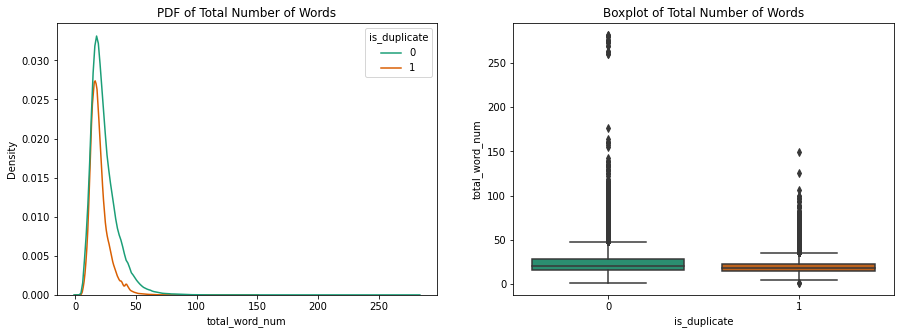

In [28]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Words')
sns.kdeplot(train_data['total_word_num'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['total_word_num'], palette="Dark2", ax=ax[1])
plt.show()

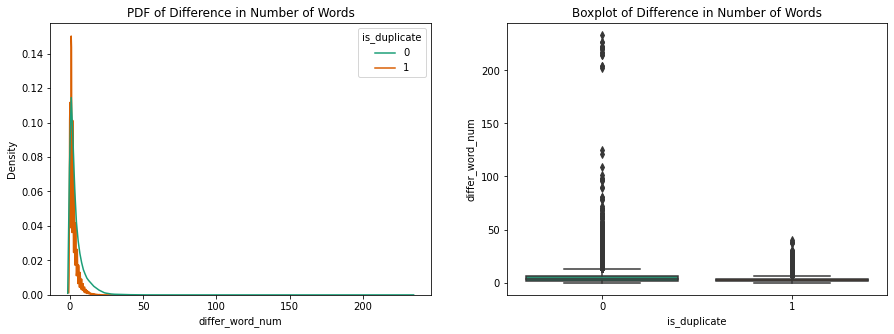

In [29]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Difference in Number of Words')
sns.kdeplot(train_data['differ_word_num'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Difference in Number of Words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['differ_word_num'], palette="Dark2", ax=ax[1])
plt.show()

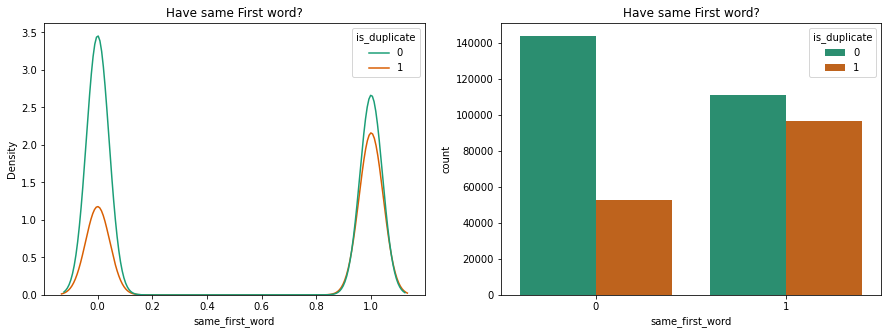

In [30]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same First word?')
sns.kdeplot(train_data['same_first_word'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same First word?')
sns.countplot(x=train_data['same_first_word'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

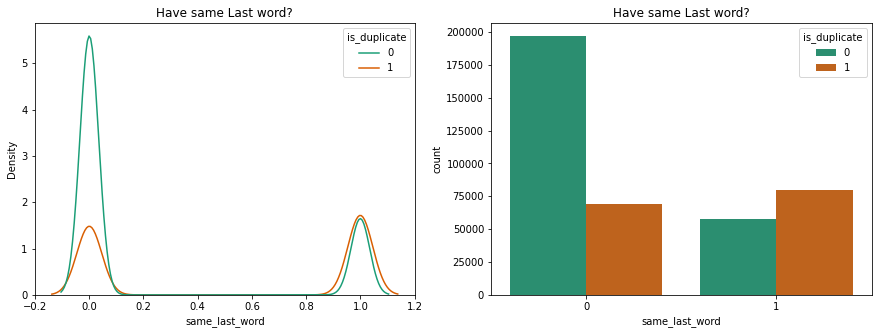

In [31]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same Last word?')
sns.kdeplot(train_data['same_last_word'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same Last word?')
sns.countplot(x=train_data['same_last_word'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

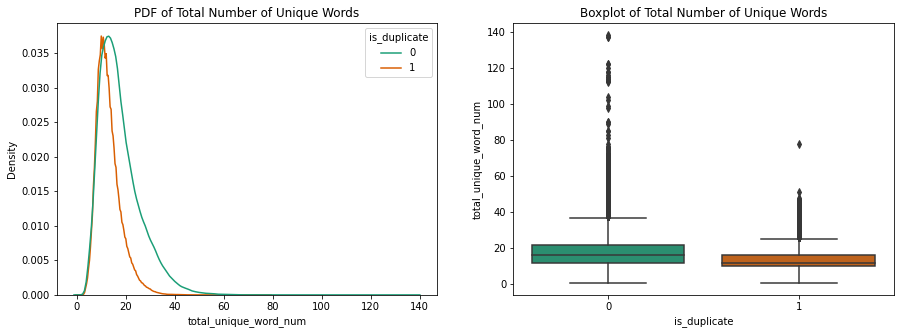

In [32]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Unique Words')
sns.kdeplot(train_data['total_unique_word_num'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Unique Words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['total_unique_word_num'], palette="Dark2", ax=ax[1])
plt.show()

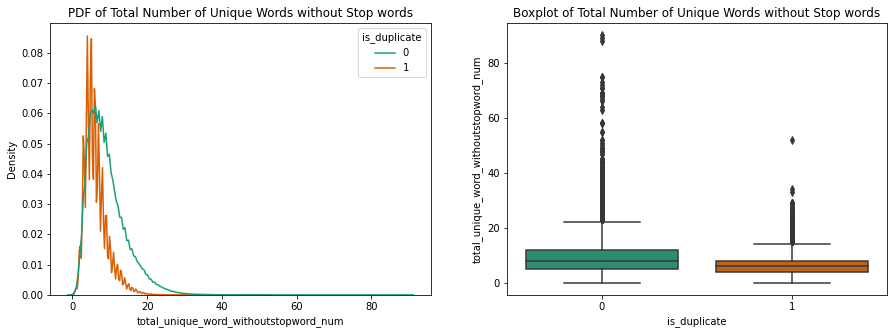

In [33]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Unique Words without Stop words')
sns.kdeplot(train_data['total_unique_word_withoutstopword_num'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Unique Words without Stop words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['total_unique_word_withoutstopword_num'], palette="Dark2", ax=ax[1])
plt.show()

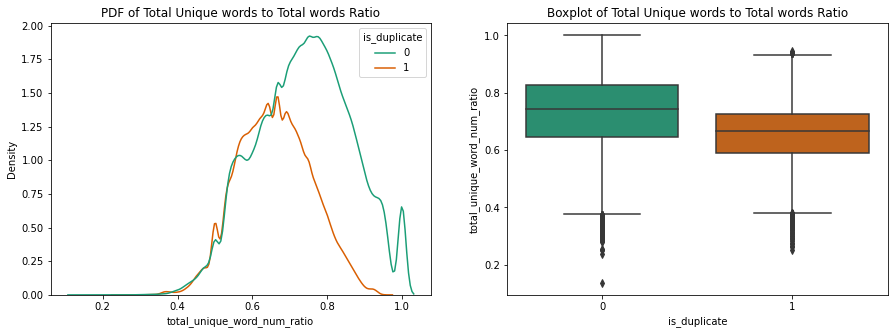

In [34]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Unique words to Total words Ratio')
sns.kdeplot(train_data['total_unique_word_num_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Unique words to Total words Ratio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['total_unique_word_num_ratio'], palette="Dark2", ax=ax[1])
plt.show()

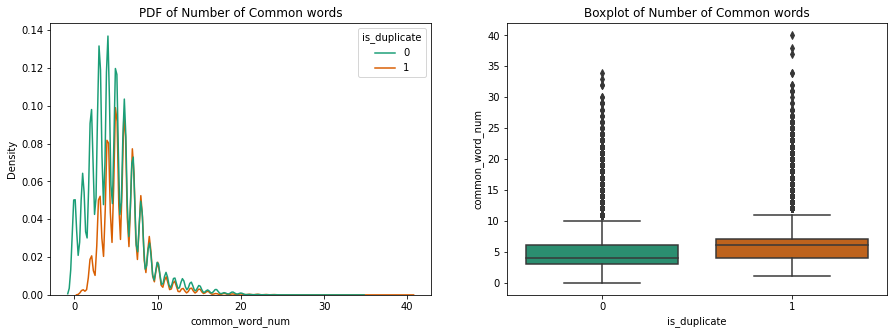

In [35]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Number of Common words')
sns.kdeplot(train_data['common_word_num'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Number of Common words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_num'], palette="Dark2", ax=ax[1])
plt.show()

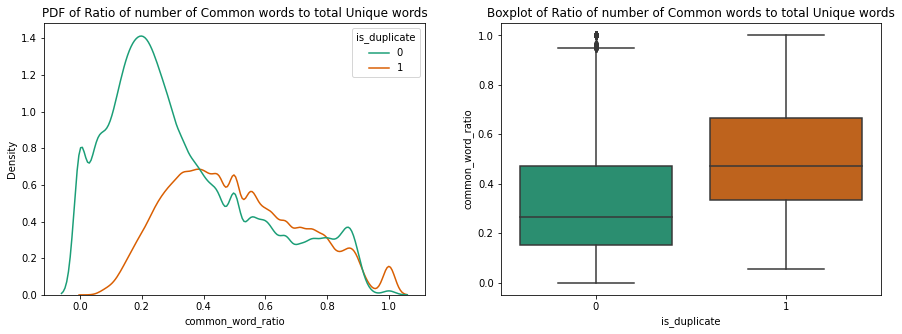

In [36]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to total Unique words')
sns.kdeplot(train_data['common_word_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to total Unique words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_ratio'], palette="Dark2", ax=ax[1])
plt.show()

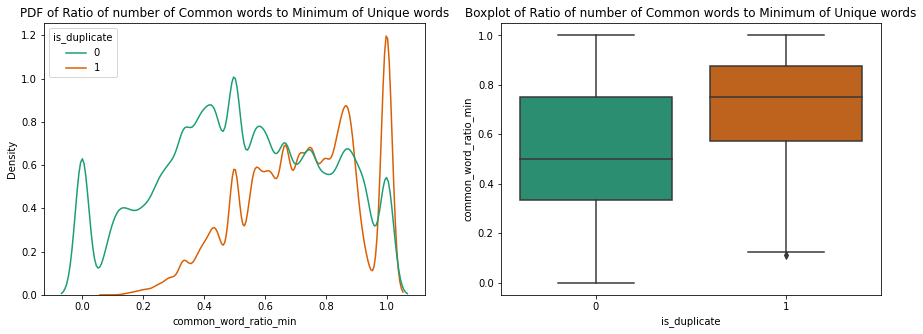

In [37]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to Minimum of Unique words')
sns.kdeplot(train_data['common_word_ratio_min'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_ratio_min'], palette="Dark2", ax=ax[1])
plt.show()

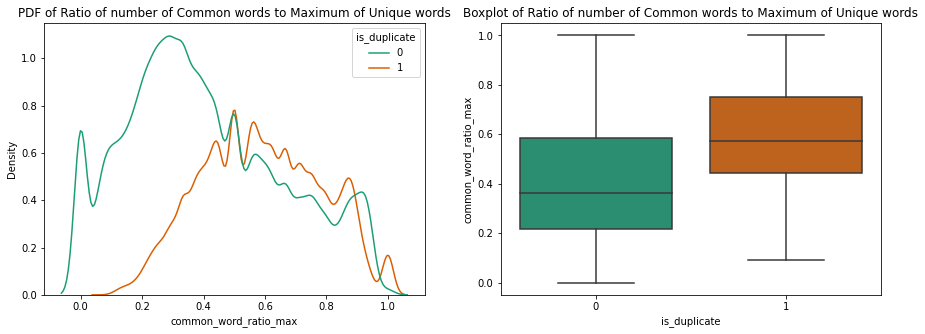

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to Maximum of Unique words')
sns.kdeplot(train_data['common_word_ratio_max'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to Maximum of Unique words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_ratio_max'], palette="Dark2", ax=ax[1])
plt.show()

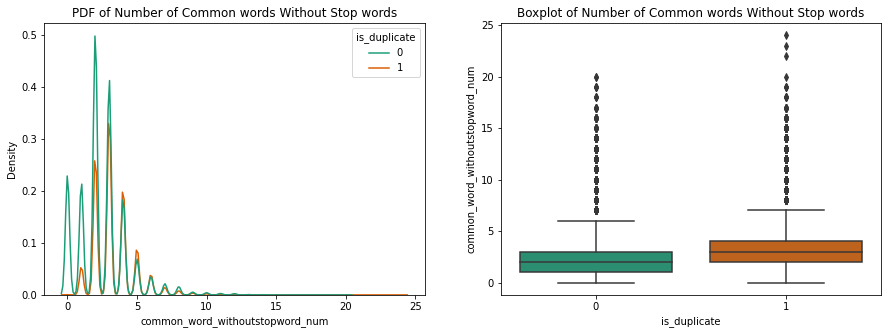

In [40]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Number of Common words Without Stop words')
sns.kdeplot(train_data['common_word_withoutstopword_num'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Number of Common words Without Stop words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_withoutstopword_num'], palette="Dark2", ax=ax[1])
plt.show()

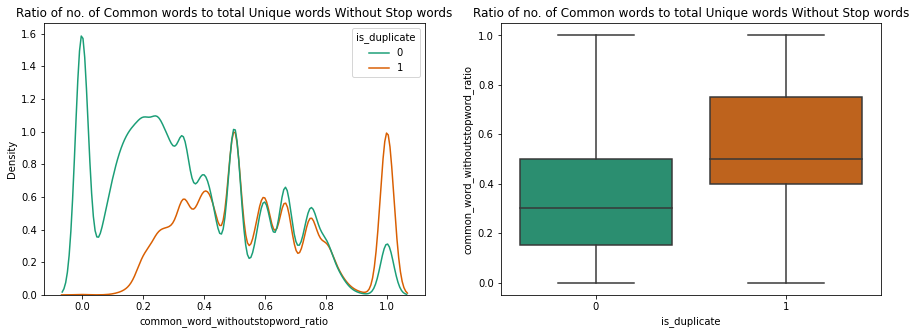

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to total Unique words Without Stop words')
sns.kdeplot(train_data['common_word_withoutstopword_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to total Unique words Without Stop words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_withoutstopword_ratio'], palette="Dark2", ax=ax[1])
plt.show()

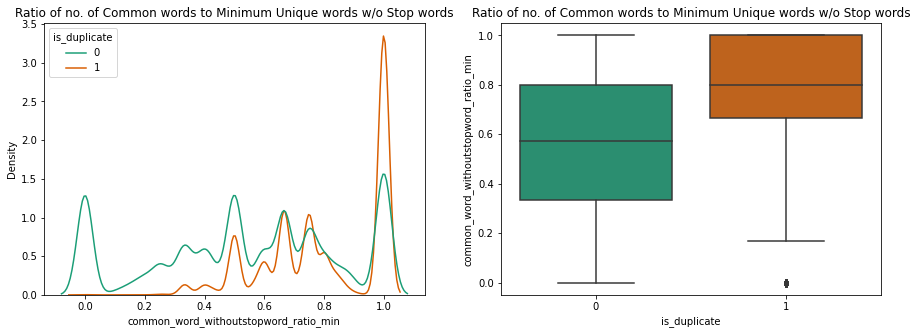

In [42]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to Minimum Unique words w/o Stop words')
sns.kdeplot(train_data['common_word_withoutstopword_ratio_min'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to Minimum Unique words w/o Stop words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_withoutstopword_ratio_min'], palette="Dark2", ax=ax[1])
plt.show()

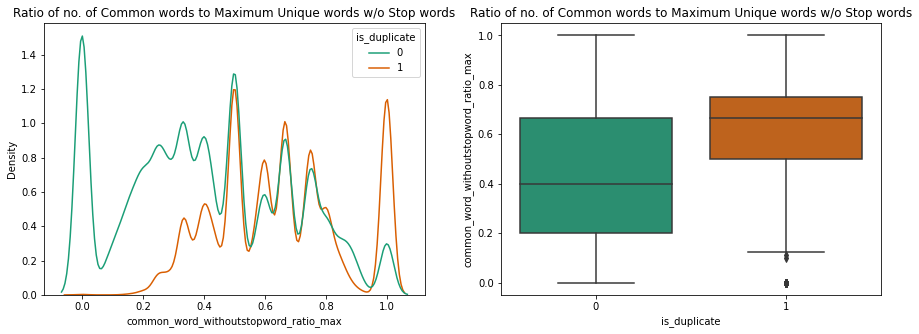

In [43]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to Maximum Unique words w/o Stop words')
sns.kdeplot(train_data['common_word_withoutstopword_ratio_max'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to Maximum Unique words w/o Stop words')
sns.boxplot(x=traindata.is_duplicate, y=train_data['common_word_withoutstopword_ratio_max'], palette="Dark2", ax=ax[1])
plt.show()

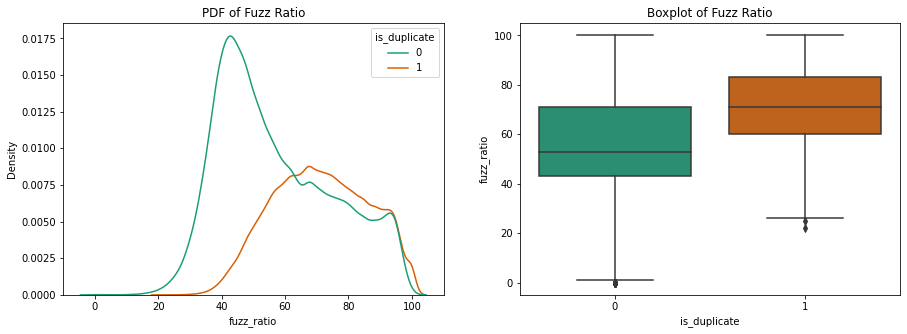

In [44]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Ratio')
sns.kdeplot(train_data['fuzz_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Ratio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['fuzz_ratio'], palette="Dark2", ax=ax[1])
plt.show()

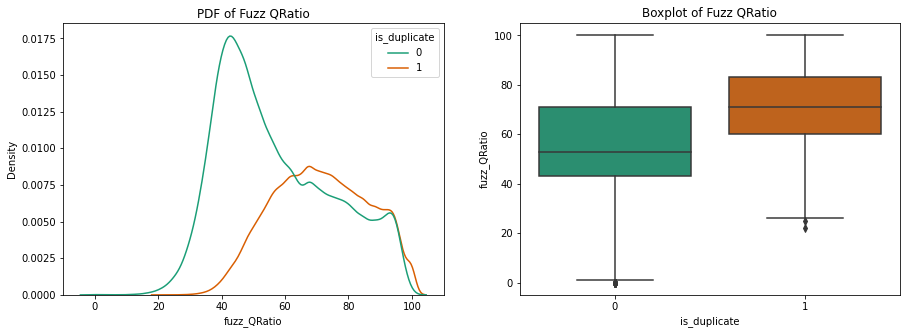

In [45]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz QRatio')
sns.kdeplot(train_data['fuzz_QRatio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz QRatio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['fuzz_QRatio'], palette="Dark2", ax=ax[1])
plt.show()

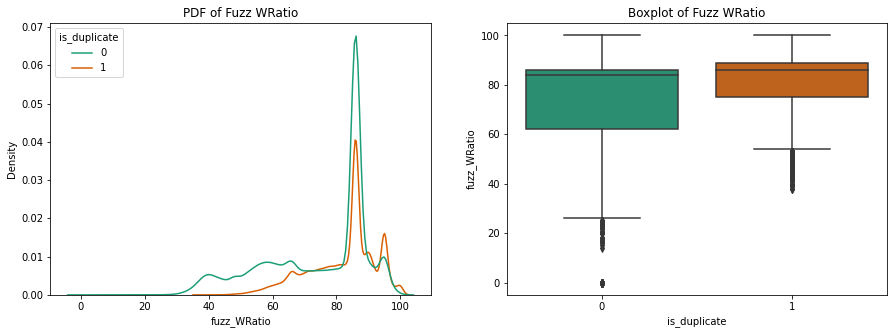

In [46]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz WRatio')
sns.kdeplot(train_data['fuzz_WRatio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz WRatio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['fuzz_WRatio'], palette="Dark2", ax=ax[1])
plt.show()

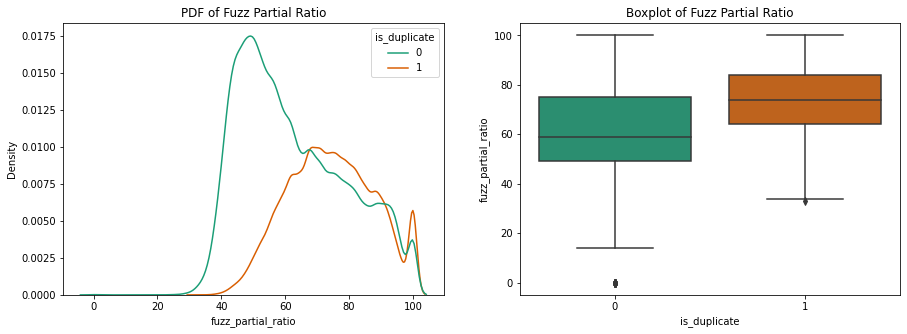

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Partial Ratio')
sns.kdeplot(train_data['fuzz_partial_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Partial Ratio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['fuzz_partial_ratio'], palette="Dark2", ax=ax[1])
plt.show()

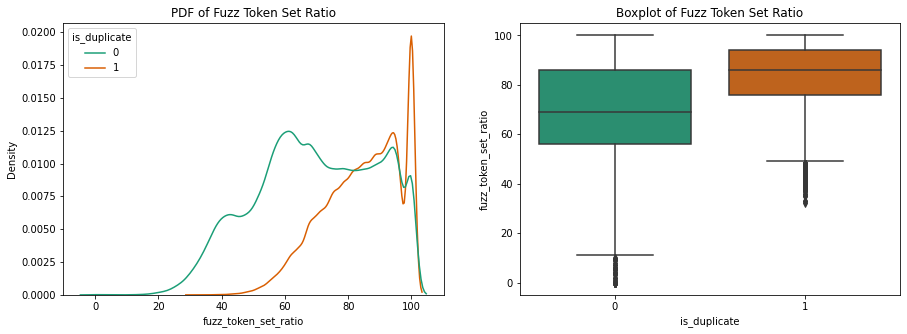

In [48]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Token Set Ratio')
sns.kdeplot(train_data['fuzz_token_set_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Token Set Ratio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['fuzz_token_set_ratio'], palette="Dark2", ax=ax[1])
plt.show()

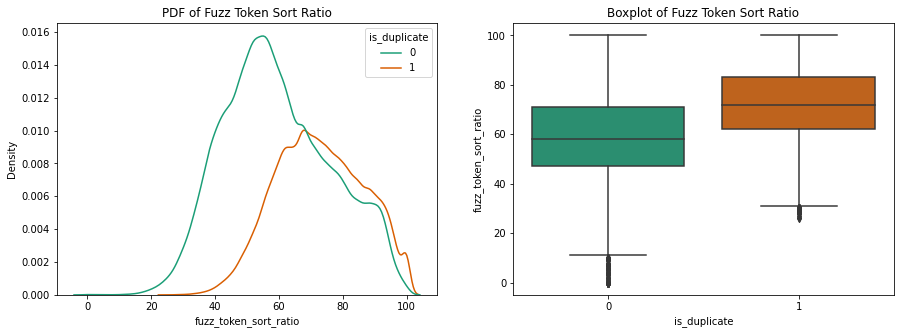

In [49]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Token Sort Ratio')
sns.kdeplot(train_data['fuzz_token_sort_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Token Sort Ratio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['fuzz_token_sort_ratio'], palette="Dark2", ax=ax[1])
plt.show()

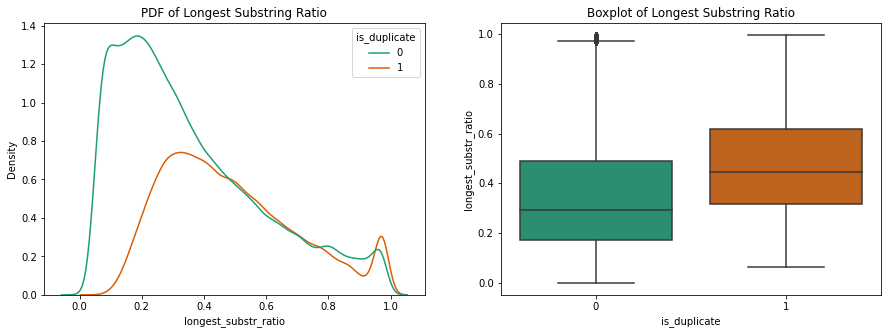

In [50]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Longest Substring Ratio')
sns.kdeplot(train_data['longest_substr_ratio'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Longest Substring Ratio')
sns.boxplot(x=traindata.is_duplicate, y=train_data['longest_substr_ratio'], palette="Dark2", ax=ax[1])
plt.show()

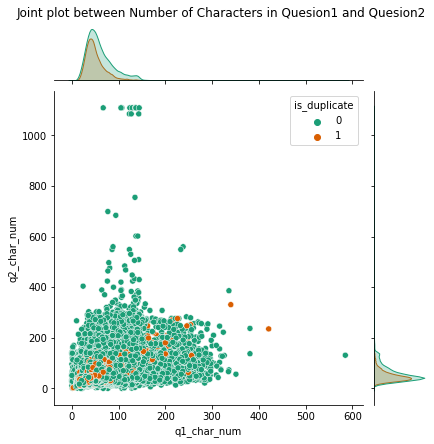

In [51]:
g = sns.jointplot(x = 'q1_char_num', y = 'q2_char_num', kind = "scatter", hue=traindata.is_duplicate, data = train_data, palette="Dark2")
g.fig.suptitle("Joint plot between Number of Characters in Quesion1 and Quesion2", y=1.02)
plt.show()

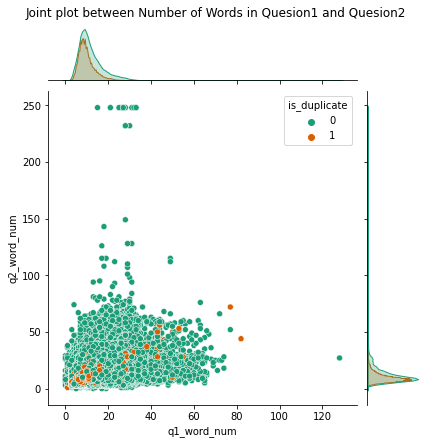

In [52]:
g = sns.jointplot(x = 'q1_word_num', y = 'q2_word_num', kind = "scatter", hue=traindata.is_duplicate, data = train_data, palette="Dark2")
g.fig.suptitle("Joint plot between Number of Words in Quesion1 and Quesion2", y=1.02)
plt.show()

In [53]:
train_data.to_csv("data/extended_nlp_features_train.csv", index=False)
test_data.to_csv("data/extended_nlp_features_test.csv", index=False)

## Embedding with SentenceBERT

In [55]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/paraphrase-mpnet-base-v2")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [56]:
# It took a lot of time, caused gpu overheat.
# So I decided to do it in batch and save them in file.
def getBertEmbeddings(data, filename):
    batch = 20000
    with open(filename, 'wb') as f:
        while(len(data)):
            tempdata = data[:batch]
            data = data[batch:]
            tempembed = model.encode(tempdata.values, device='cuda')
            np.save(f, tempembed, allow_pickle=True)

In [57]:
# Getting SentenceBERT embedding of train data
getBertEmbeddings(train_data['question1_final'], 'temp_train_question1_sentenceBERT.npy')
getBertEmbeddings(train_data['question2_final'], 'temp_train_question2_sentenceBERT.npy')

In [58]:
# Getting SentenceBERT embedding of test data
getBertEmbeddings(test_data['question1_final'], 'temp_test_question1_sentenceBERT.npy')
getBertEmbeddings(test_data['question2_final'], 'temp_test_question2_sentenceBERT.npy')

In [59]:
# Defining cosine similarity and euclidean distance between two vectors
def cosine_euclidean(u, v):
    return np.array([np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)), np.linalg.norm(u - v)])

In [60]:
# open .npy files and loop through the sentence embeddings for train data
with open('temp_train_question1_sentenceBERT.npy', 'rb') as q1_vec, open('temp_train_question2_sentenceBERT.npy', 'rb') as q2_vec:
    distances = []
    while True:
        try:
            q1_20k = np.load(q1_vec, allow_pickle=True)
            q2_20k = np.load(q2_vec, allow_pickle=True)
            for q1,q2 in zip(q1_20k, q2_20k):
                dists = cosine_euclidean(q1, q2)
                distances.append(dists)
        except IOError as e:
            distances = np.array(distances)
            break

In [61]:
distances = pd.DataFrame(distances, columns=['cosine_simlarity_bert', 'euclidean_distance_bert'])

In [62]:
train_data = pd.concat([train_data, pd.DataFrame(distances)], axis=1)

In [63]:
# open .npy files and loop through the sentence embeddings for test data
with open('temp_test_question1_sentenceBERT.npy', 'rb') as q1_vec, open('temp_test_question2_sentenceBERT.npy', 'rb') as q2_vec:
    distances = []
    while True:
        try:
            q1_20k = np.load(q1_vec, allow_pickle=True)
            q2_20k = np.load(q2_vec, allow_pickle=True)
            for q1,q2 in zip(q1_20k, q2_20k):
                dists = cosine_euclidean(q1, q2)
                distances.append(dists)
        except IOError as e:
            distances = np.array(distances)
            break
distances = pd.DataFrame(distances, columns=['cosine_simlarity_bert', 'euclidean_distance_bert'])
test_data = pd.concat([test_data, pd.DataFrame(distances)], axis=1)

## EDA on new features related to SentenceBERT

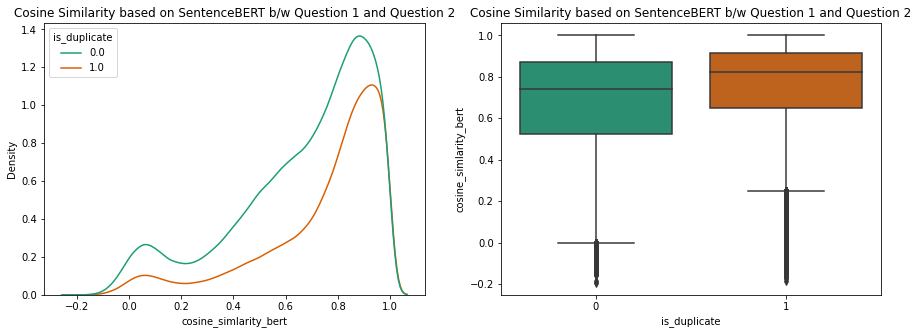

In [64]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.kdeplot(train_data['cosine_simlarity_bert'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.boxplot(x=traindata.is_duplicate, y=train_data['cosine_simlarity_bert'], palette="Dark2", ax=ax[1])
plt.show()

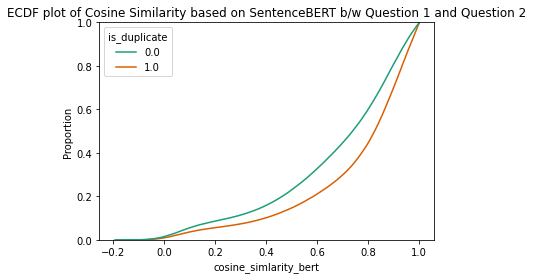

In [65]:
plt.title('ECDF plot of Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.axes_style("whitegrid")
sns.ecdfplot(x=train_data['cosine_simlarity_bert'], hue=traindata.is_duplicate, palette="Dark2")
plt.show()

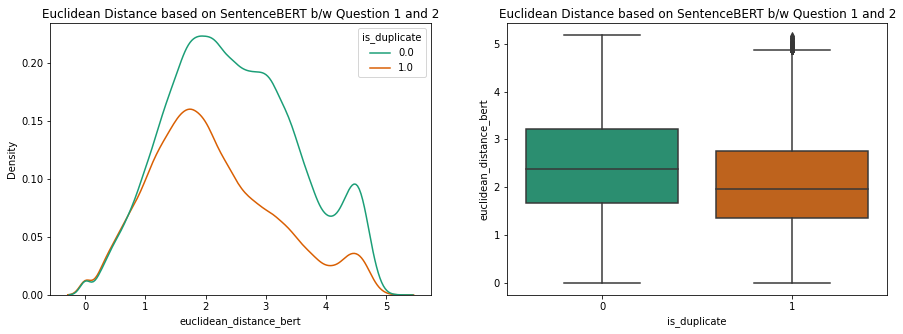

In [66]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Euclidean Distance based on SentenceBERT b/w Question 1 and 2')
sns.kdeplot(train_data['euclidean_distance_bert'], hue=traindata.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Euclidean Distance based on SentenceBERT b/w Question 1 and 2')
sns.boxplot(x=traindata.is_duplicate, y=train_data['euclidean_distance_bert'], palette="Dark2", ax=ax[1])
plt.show()

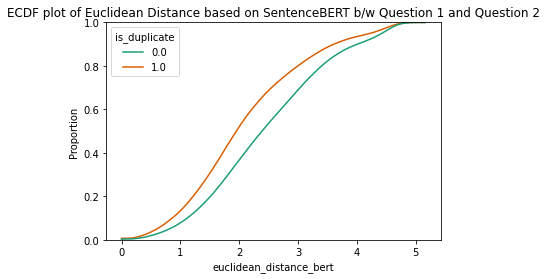

In [67]:
plt.title('ECDF plot of Euclidean Distance based on SentenceBERT b/w Question 1 and Question 2')
sns.axes_style("whitegrid")
sns.ecdfplot(x=train_data['euclidean_distance_bert'], hue=traindata.is_duplicate, palette="Dark2")
plt.show()

## Final Preprocessing

In [68]:
train_data.drop(columns=['question1_final', 'question2_final'], axis=1, inplace=True)

In [69]:
train_data = train_data.to_numpy()

In [70]:
scaler = MinMaxScaler()

In [71]:
scaler.fit_transform(train_data)
train_data

array([[6.50000000e+01, 5.60000000e+01, 1.40000000e+01, ...,
        9.82456140e-01, 8.91494215e-01, 1.53108728e+00],
       [4.80000000e+01, 8.50000000e+01, 1.00000000e+01, ...,
        5.71428571e-01, 6.09401345e-01, 2.79872847e+00],
       [7.00000000e+01, 5.40000000e+01, 1.40000000e+01, ...,
        1.81818182e-01, 6.65073633e-01, 2.66673827e+00],
       ...,
       [1.60000000e+01, 1.70000000e+01, 4.00000000e+00, ...,
        4.70588235e-01,            nan,            nan],
       [8.70000000e+01, 1.20000000e+02, 1.70000000e+01, ...,
        5.68181818e-02,            nan,            nan],
       [3.60000000e+01, 4.40000000e+01, 8.00000000e+00, ...,
        6.21621622e-01,            nan,            nan]])

In [72]:
# For test data
test_data.drop(columns=['question1_final', 'question2_final'], axis=1, inplace=True)
test_data = test_data.to_numpy()
test_data = scaler.transform(test_data)
test_data

array([[0.09401709, 0.06041479, 0.0859375 , ..., 0.25124378, 0.62265475,
        0.59195244],
       [0.10940171, 0.03697024, 0.109375  , ..., 0.40677565, 0.79336938,
        0.4548728 ],
       [0.1008547 , 0.02524797, 0.109375  , ..., 0.41585178, 0.83977757,
        0.40547467],
       ...,
       [0.1042735 , 0.04328224, 0.078125  , ..., 0.28713575, 0.52086247,
        0.69004651],
       [0.18974359, 0.11000902, 0.15625   , ..., 0.40378465, 0.93764583,
        0.23590894],
       [0.0974359 , 0.03967538, 0.0625    , ..., 0.46898839, 0.75761155,
        0.48530176]])

In [73]:
with open('temp_testdata.npy', 'wb') as f:
    batch = 20000
    while(len(test_data)):
        tempdata = test_data[:batch]
        test_data = test_data[batch:]
        np.save(f, tempdata, allow_pickle=True)

In [74]:
def loadVectors(filename):
    with open(filename, 'rb') as f:
        q_vectors = []
        while True:
            try:
                q_vec = np.load(f, allow_pickle=True)
                q_vectors.extend(list(q_vec))
            except IOError as e:
                q_vectors = np.array(q_vectors)
                break
    return q_vectors

In [75]:
train_question1_vec = loadVectors('temp_train_question1_sentenceBERT.npy')
train_question2_vec = loadVectors('temp_train_question2_sentenceBERT.npy')

In [77]:
train_data.shape

(404290, 28)

In [78]:
train_question1_vec.shape

(404287, 768)

In [76]:
train_data = np.hstack((train_data, train_question1_vec, train_question2_vec))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 404290 and the array at index 1 has size 404287